## 1. Data loading and pre-processing

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.parse
from collections import defaultdict, deque
from src.utils.pagerank_utils import *

In [6]:
# Load all the data from the tsv files, skipping the headers and specifying column names
DATA_FOLDER = 'data/wikispeedia_paths-and-graph/'
articles = pd.read_csv(DATA_FOLDER + 'articles.tsv', sep='\t', skiprows=12, names=['article'])
categories = pd.read_csv(DATA_FOLDER + 'categories.tsv', sep='\t', skiprows=12, names=['article', 'category'])
links = pd.read_csv(DATA_FOLDER + 'links.tsv', sep='\t', skiprows=11, names=['linkSource', 'linkTarget'])
paths_finished = pd.read_csv(DATA_FOLDER + 'paths_finished.tsv', sep='\t', skiprows=15, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
paths_unfinished = pd.read_csv(DATA_FOLDER + 'paths_unfinished.tsv', sep='\t', skiprows=16, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'])

In [7]:
# Decode the URL-encoded article titles
articles = articles.map(urllib.parse.unquote)
categories = categories.map(urllib.parse.unquote)
links = links.map(urllib.parse.unquote)
paths_finished['path'] = paths_finished['path'].map(urllib.parse.unquote)
paths_unfinished['path'] = paths_unfinished['path'].map(urllib.parse.unquote)

In [8]:
# Turn the paths into an array of article titles
paths_finished['path'] = paths_finished['path'].str.split(';')
paths_unfinished['path'] = paths_unfinished['path'].str.split(';')

In [9]:
# Articles is a 1-column DataFrame, so convert it to a Series
articles = pd.Series(articles['article'])

## 2. Compute probabilities and entropies

### 2.A. Prior click probability

![Formula for the prior click probability](./images/probs_prior.png)

In [10]:
# Prior click probability

# The probability to click on each of article a’s L_a outlinks is the same for all outlinks
# So we don’t need a third dimension to index the specific outlinks

# Actually, it doesn’t depend either on the goal, because our prior is that the links are clicked randomly

# Count the outlinks of each article to get the probability of clicking on any of them
out_degree = links.groupby('linkSource').size()
probs_prior = 1 / out_degree
# Create a Series indexed by 'linkSource' that gives a list of all the source’s outlinks
out_links = links.groupby('linkSource')['linkTarget'].agg(list)
# Convert it to a default dict to cover for articles that are encountered in paths but that have no outlinks
#out_links = defaultdict(int, out_links.to_dict())

### 2.B. Posterior click probability

![Formula for the posterior click probability](./images/probs_posterior.png)

In [11]:
# N(A=a, G=g): the number of times 'a' was encountered on paths for which 'g' was the goal
count_goal_article = defaultdict(lambda: defaultdict(int))
# N(A’=a’, A=a, G=g): the number of times a’ was clicked in this situation
count_goal_article_article_clicked = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
# Filter out the paths that have only one article, because I have no clue what they mean
paths = paths_finished['path'][paths_finished['path'].apply(len) > 1]

# Create simplified paths by getting rid of the backtracking steps, and going straight
# where the player ended up going after backtracking
def straighten_path(path):
    stack = deque()
    for article in path:
        if article == '<':
            stack.pop()
        else:
            stack.append(article)
    return list(stack)

paths_no_backtrack = paths.apply(straighten_path)

# Count the occurrences of a, a’ and g along every path
for path in paths_no_backtrack:
    goal = path[-1]
    # Iterate through the path by getting each time one article and the one that was clicked from it.
    # It starts at (start_article, first_article_clicked) and ends with (before_last_article, goal).
    for article, article_clicked in zip(path, path[1:]):
        count_goal_article[goal][article] += 1
        count_goal_article_article_clicked[goal][article][article_clicked] += 1

In [12]:
# Posterior click probabilities
probs_posterior = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
# alpha_ is the Dirichlet parameter representing the initial confidence in the uniform prior distribution
alpha_ = 0.1

for g, article_counts in count_goal_article.items():
    for a, count in article_counts.items():
        for a_ in out_links[a]:
            # Use the formula (1) from the Wikispeedia paper
            probs_posterior[g][a][a_] = (
                    (count_goal_article_article_clicked[g][a][a_] + alpha_)
                    /
                    (count_goal_article[g][a] + alpha_ * out_degree[a])
            )

### 2.C. Prior and posterior entropies

In [15]:
# Compute the prior and posterior entropy at each article along the path, except for the goal,
# because entropy is 0 once we have reached the goal.

def path_to_prior_entropy(path):
    return [-1 * out_degree[a] * probs_prior[a] * np.log(probs_prior[a]) for a in path[:-1]]

def path_to_posterior_entropy(path):
    g = path[-1]
    return [(-1 * sum([prob * np.log(prob) for prob in probs_posterior[g][a].values()])) for a in path[:-1]]

entropies_prior = paths_no_backtrack.apply(path_to_prior_entropy)
entropies_posterior = paths_no_backtrack.apply(path_to_posterior_entropy)

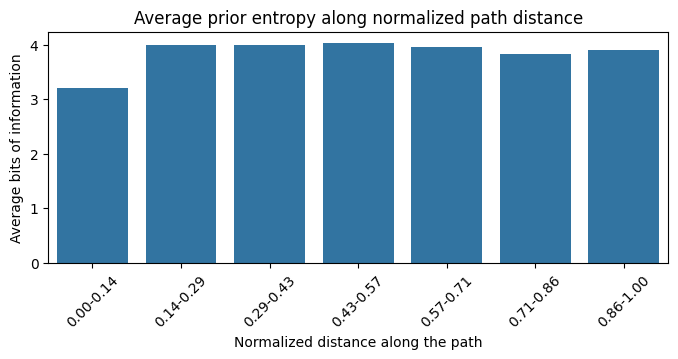

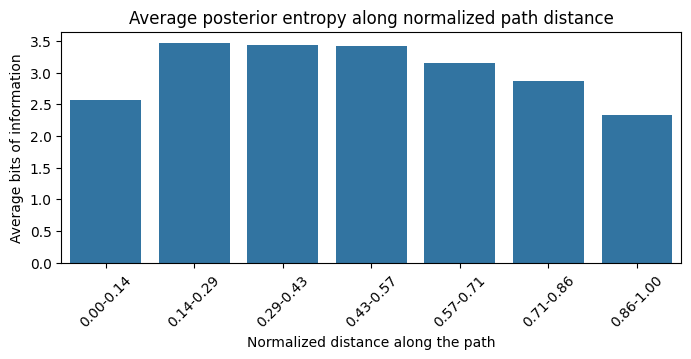

In [16]:
# Visualize the entropies like in Fig. 2 of the Wikispeedia paper
def plot_normalized_positions(series, graph_title, n_bins=7):
    """
    Create a bar plot of binned averages along the length of an array,
    but plotted along an x-axis normalized to [0,1].
    
    Parameters:
    series: pandas.Series where each element is an array of numbers
    graph_titre: string with the name of the quantity plotted
    n_bins: number of bins to divide the [0,1] interval into
    """
    # Create empty lists to store normalized positions and values
    all_positions = []
    all_values = []

    # Process each array in the series
    for arr in series:
        length = len(arr)
        # Create normalized positions for this array
        positions = np.linspace(0, 1, length)

        all_positions.extend(positions)
        all_values.extend(arr)

    # Create a DataFrame with the normalized positions and values
    df = pd.DataFrame({
        'position': all_positions,
        'value': all_values
    })

    # Create bins and calculate statistics for each bin
    df['bin'] = pd.cut(df['position'], bins=n_bins, labels=[f'{i/n_bins:.2f}-{(i+1)/n_bins:.2f}' for i in range(n_bins)])

    bin_stats = df.groupby('bin', observed=True).agg({
        'value': ['mean']
    }).reset_index()

    # Flatten the column names
    bin_stats.columns = ['bin', 'mean']

    # Create the plot
    plt.figure(figsize=(8, 3))
    sns.barplot(data=bin_stats, x='bin', y='mean')

    plt.title(f'Average {graph_title} along normalized path distance')
    plt.xlabel('Normalized distance along the path')
    plt.ylabel('Average bits of information')
    plt.xticks(rotation=45)

    return plt.gcf()

plot_normalized_positions(entropies_prior, 'prior entropy')
plt.show()
plot_normalized_positions(entropies_posterior, 'posterior entropy')
plt.show()

## 3. Split the paths

### 3.A. Compute “information gain”

This represents how much information we gain by looking at the click distribution

In [17]:
# Define a function to subtract two lists element-wise
def subtract_lists(list1, list2):
    return [a - b for a, b in zip(list1, list2)]

# Subtract posterior entropy to prior entropy element-wise in each path to obtain information gain
information_gain = entropies_prior.combine(entropies_posterior, subtract_lists)

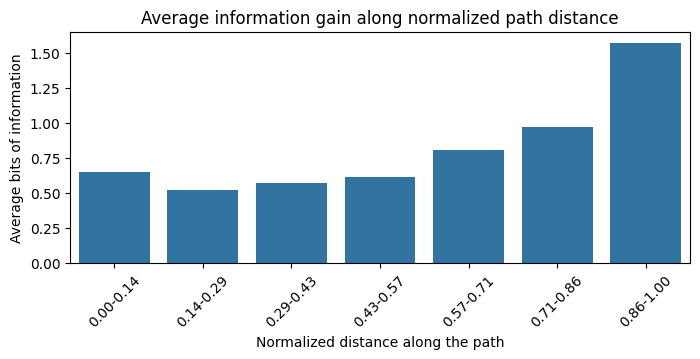

In [18]:
plot_normalized_positions(information_gain, 'information gain')
plt.show()

This is similar to what the paper gets:

![information gain graph from the paper](./images/fig_2_paper.png)

### 3.B. Get the splitting point and split the paths

In [19]:
# Add all the “homing in” parts of the paths in the array, by splitting
# the paths at the point of minimum information

# Get the index of the point of lowest information gain for each path
argmin_info_gain = information_gain.apply(np.argmin)
# Split the path at this point and keep only the second part, corresponding to the “homing in” phase
paths_homing_in = pd.Series([path[argmin_info_gain[i]:] for i, path in paths_no_backtrack.items()])

## 4. Compute embedding distances

We now need to get a list of all the article titles whose embedding we need to compute, as well as the list of pairs of articles between which we need to compute the distance.

In [20]:
# Compute the set of all articles encountered in the paths_homing_in
# Every article encountered along a goal has a defined distance with the goal
all_distance_pairs = set()
all_articles = set()
for path in paths_homing_in:
    goal  = path[-1]
    for article in path:
        all_articles.add(article)
        all_distance_pairs.add((article, goal))

We use the sentence-transformers library to load the pre-trained BERT model and compute embeddings for each of our article titles. Then, we compute distances between these embeddings models, using both cosine similarity and Euclidean distance, which we return in a dataframe `similarities`.

In [2]:
from src.scripts.generate_embeddings_distances import get_embeddings_distances
similarities = get_embeddings_distances(None, None, 'data/article_similarities.csv')

## 5. Make the LLMs play Wikispeedia games

Here we run our script to make the LLMs play Wikispeedia games on the same starting and target articles as in `paths_finished`, and we gather the resulting game paths in DataFrames. We generate do twice, once using `gpt-4o-mini` from OpenAI and once using `mistral-large-2407`.

We already ran the script `run_llm_games.py` to generate the files, so we can just load them.

In [22]:
llm_choices_gpt4omini = pd.read_csv('data/llm_choices.tsv', sep='\t')
llm_choices_mistral_large = pd.read_csv('data/llm_choices_mistral_1.tsv', sep='\t')
llm_paths_gpt4omini = pd.read_csv('data/llm_paths.tsv', sep='\t')
llm_paths_misrtal_large = pd.read_csv('data/llm_paths_mistral_1.tsv', sep='\t')

## 4. Compute semantic distances from paths

We compute the path-specific distances along all our “homing-in” paths, as described in section 3 of the paper:

![formula for the path-specific distance from the paper](./images/path_specific_distance.png)

### 4.A. PageRank

We first compute the PageRank of each article.

In [23]:
M, nodes = build_transition_matrix(links)
ranks = pagerank(M)

#Properties that were tested and validated: every rank is inferior to 1, the sum of all ranks is 1.
#Dictionary of pagerank per article.
PAGERANK_SCORES = dict(zip(nodes, ranks))

- Nous avons 5 articles qui ont des inwards links mais pas d'outgoing link (dandling nodes): ['Directdebit', 'Duchenne_muscular_dystrophy', 'Klinefelter%27s_syndrome', 'Local_community', 'Osteomalacia']
- Le plus haut pagerank est atteint par l'article Etats-Unis
- Le pagerank le plus bas est atteint par l'article %C3%81ed%C3%A1n_mac_Gabr%C3%A1in

### 4.B. Path-specific and path-independent distances

We now compute the path-specific distance as described above in equation (2), as well as the path-independent distance, as described in equation (4) of the paper:

![formula for the path-independent distance from the paper](./images/path_independent_distance.png)

In [25]:
#2 Initialize the distances matrix
nodes = np.unique(links[['linkSource', 'linkTarget']].values.flatten())
distances_counts = pd.DataFrame(0, index=nodes, columns=nodes) #used in computing the average of path distances.
distances = pd.DataFrame(0.0, index=nodes, columns=nodes) # Interface: distances[article1][article2] = d(article1, article2)

#define path distance computation function
def compute_path_distance(i, path):
    goal = path[-1]
    sum_p = 0
    for i in range(i, len(path) - 1):
        sum_p -= np.log(probs_posterior[goal][path[i]][path[i+1]])
    return sum_p / np.log(PAGERANK_SCORES[goal])

#fill in distances without normalization and distances_count for one path
def path_distances_traversal(path):
    goal = path[-1]
    for i in range(0, len(path) - 1): # len(path) - 1: We don't consider the distance from the goal to itself
        if path[i] not in links['linkSource'].values or goal not in links['linkSource'].values:
            continue
        distances.loc[goal, path[i]] += compute_path_distance(i, path)
        distances_counts.loc[goal, path[i]] += 1
    return path

#3 Compute the distances and distances_counts matrix by passing through all the paths and incrementing the two matrices accordingly
paths_homing_in.apply(path_distances_traversal)

#4 Normalize the distances according to the number of occurences of given distance in the paths
distances_counts[distances_counts == 0] = 1 # avoid dividing by zero
distances = distances / distances_counts

# Put every undefined distance to a negative value.
distances[distances == 0] = -1

/tmp/ipykernel_78111/1910883007.py:11: RuntimeWarning: divide by zero encountered in log
  sum_p -= np.log(probs_posterior[goal][path[i]][path[i+1]])
